<a href="https://colab.research.google.com/github/doronschwartz/NLP/blob/main/HW2/HW2_Part_3_correct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif
from nltk.tokenize import word_tokenize
import nltk

# Download NLTK resources
nltk.download('punkt')

# Load the first Excel file (news-pal.xlsx)
url_pal = "https://github.com/rosenfa/ai/blob/master/news-pal.xlsx?raw=true"
df_pal = pd.read_excel(url_pal)

# Load the second Excel file (news-israel.xlsx)
url_israel = "https://github.com/rosenfa/ai/blob/master/news-israel.xlsx?raw=true"
df_israel = pd.read_excel(url_israel)

df_israel.dropna(inplace=True)
df_pal.dropna(inplace=True)


# Add a 'target' column to both dataframes
df_pal['target'] = False  # Assuming 'false' for news-pal.xlsx
df_israel['target'] = True   # Assuming 'true' for news-israel.xlsx


# Concatenate the two dataframes
df_combined = pd.concat([df_pal, df_israel], ignore_index=True)
df_combined.dropna(inplace=True)

# Tokenize the documents
#tokenized_documents = [word_tokenize(doc) for doc in df_combined['Content'].dropna()]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print(df_pal.size)
print(df_israel.size)
print(df_combined.size)

950
950
1900


In [ ]:
df_combined

,Content,target
0,": Qatar, the mediator in the Gaza truce talks,...",False
1,Hamas says it holds US President Joe Biden and...,False
2,Israeli attacks in the besieged Gaza Strip amo...,False
3,Israeli warplanes and artillery bomb several a...,False
4,"""Israel respects no international laws or conv...",False
...,...,...
945,"White nationalists, usually anti-Muslim bigots...",True
946,"Why Israel agreed to the hostage deal, and how...",True
947,With the rise of campus antisemitism around th...,True
948,WZO offers mobile showers for IDF soldiers in ...,True


In [ ]:
# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(df_combined))
train_samples = df_combined[:-num_validation_samples]
training_sentences = train_samples['Content'].values.astype(str)  # Convert to NumPy array and ensure string type
labels = df_combined['target']

In [ ]:
val_samples = df_combined[-num_validation_samples:]
testing_sentences  = val_samples['Content'].values.astype(str)  # Convert to NumPy array and ensure string type
training_labels = labels[:-num_validation_samples]
testing_labels = labels[-num_validation_samples:]

In [ ]:
training_sentences[0]

': Qatar, the mediator in the Gaza truce talks, has confirmed that a humanitarian pause has been agreed on.'

In [ ]:
# Vocabulary size of the tokenizer
vocab_size = 1000

# Maximum length of the padded sequences
max_length = 32

# Output dimensions of the Embedding layer
embedding_dim = 16

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [ ]:
import tensorflow as tf

# Initialize a GlobalAveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define sample array
sample_array = np.array([[[10,2],[1,3],[1,1]]])

# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


In [ ]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 32, 16)            16000     
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_39 (Dense)            (None, 24)                12312     
                                                                 
 dense_40 (Dense)            (None, 1)                 25        
                                                                 
Total params: 28337 (110.69 KB)
Trainable params: 28337 (110.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
num_epochs = 30

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
24/24 - 1s - loss: 0.6667 - accuracy: 0.6197 - val_loss: 0.8368 - val_accuracy: 0.0000e+00 - 1s/epoch - 42ms/step
Epoch 2/30
24/24 - 0s - loss: 0.5975 - accuracy: 0.6671 - val_loss: 0.9111 - val_accuracy: 0.1368 - 95ms/epoch - 4ms/step
Epoch 3/30
24/24 - 0s - loss: 0.5188 - accuracy: 0.8118 - val_loss: 0.8323 - val_accuracy: 0.4158 - 94ms/epoch - 4ms/step
Epoch 4/30
24/24 - 0s - loss: 0.3916 - accuracy: 0.9013 - val_loss: 0.7426 - val_accuracy: 0.5263 - 78ms/epoch - 3ms/step
Epoch 5/30
24/24 - 0s - loss: 0.2466 - accuracy: 0.9500 - val_loss: 0.6873 - val_accuracy: 0.6158 - 98ms/epoch - 4ms/step
Epoch 6/30
24/24 - 0s - loss: 0.1472 - accuracy: 0.9750 - val_loss: 0.5462 - val_accuracy: 0.7211 - 79ms/epoch - 3ms/step
Epoch 7/30
24/24 - 0s - loss: 0.0906 - accuracy: 0.9882 - val_loss: 0.5353 - val_accuracy: 0.7368 - 95ms/epoch - 4ms/step
Epoch 8/30
24/24 - 0s - loss: 0.0579 - accuracy: 0.9934 - val_loss: 0.6433 - val_accuracy: 0.6842 - 79ms/epoch - 3ms/step
Epoch 9/30
24/24 - 0s

In [ ]:
# Build model2
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 32, 16)            16000     
                                                                 
 global_average_pooling1d_7  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_41 (Dense)            (None, 24)                408       
                                                                 
 dense_42 (Dense)            (None, 1)                 25        
                                                                 
Total params: 16433 (64.19 KB)
Trainable params: 16433 (64.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now with the simple flatten:

In [ ]:
# Compile the model
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
num_epochs = 30

# Train the model
history = model2.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
24/24 - 1s - loss: 0.6861 - accuracy: 0.6184 - val_loss: 0.7315 - val_accuracy: 0.0000e+00 - 1s/epoch - 56ms/step
Epoch 2/30
24/24 - 0s - loss: 0.6682 - accuracy: 0.6250 - val_loss: 0.7659 - val_accuracy: 0.0000e+00 - 122ms/epoch - 5ms/step
Epoch 3/30
24/24 - 0s - loss: 0.6442 - accuracy: 0.6250 - val_loss: 0.7965 - val_accuracy: 0.0000e+00 - 119ms/epoch - 5ms/step
Epoch 4/30
24/24 - 0s - loss: 0.6102 - accuracy: 0.6329 - val_loss: 0.7989 - val_accuracy: 0.0684 - 112ms/epoch - 5ms/step
Epoch 5/30
24/24 - 0s - loss: 0.5645 - accuracy: 0.7224 - val_loss: 0.7632 - val_accuracy: 0.3211 - 169ms/epoch - 7ms/step
Epoch 6/30
24/24 - 0s - loss: 0.5083 - accuracy: 0.8408 - val_loss: 0.6962 - val_accuracy: 0.5947 - 146ms/epoch - 6ms/step
Epoch 7/30
24/24 - 0s - loss: 0.4461 - accuracy: 0.8816 - val_loss: 0.5958 - val_accuracy: 0.7316 - 120ms/epoch - 5ms/step
Epoch 8/30
24/24 - 0s - loss: 0.3822 - accuracy: 0.8974 - val_loss: 0.5533 - val_accuracy: 0.7579 - 131ms/epoch - 5ms/step
Epoch 

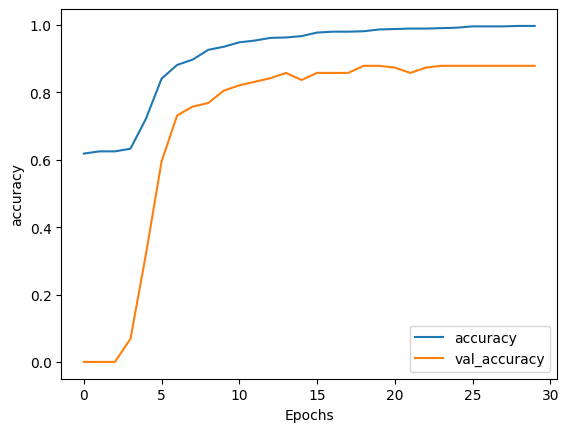

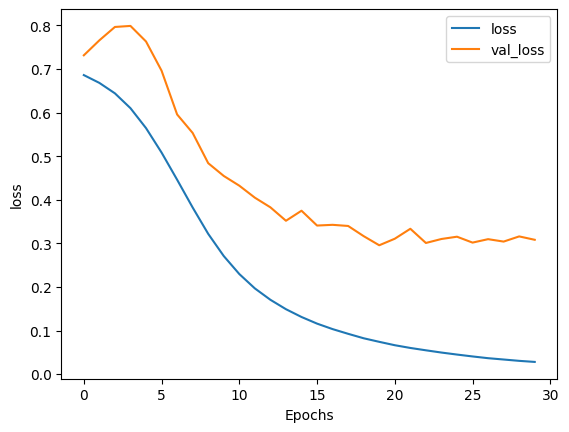

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)

(1000, 16)


# Building a transfer learning model based on Glove

In [ ]:
import gensim.downloader as api

In [ ]:
glove_model = api.load("glove-wiki-gigaword-300")
embedding_dim = glove_model.vector_size

Train test split with this seed

In [ ]:
from sklearn.model_selection import train_test_split

samples = df_combined['Content'].values
labels = df_combined['target'].values

# Split the dataset into training and validation sets
train_samples, val_samples, train_labels, val_labels = train_test_split(samples, labels, test_size=0.2, random_state=1337)

In [ ]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
vocab_size = len(word_index)
num_tokens = len(voc) + 2
embedding_matrix = np.zeros((num_tokens, embedding_dim))

hits = 0
misses = 0

# Prepare embedding matrix
for word, i in word_index.items():
    if word in glove_model:
      hits += 1
      embedding_matrix[i] = glove_model[word]
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 3601 words (749 misses)


Build the embedding layer

In [ ]:
from tensorflow.keras.layers import Embedding

int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

Construct the model

In [ ]:
model = Sequential([
    Embedding(input_dim=num_tokens, output_dim=embedding_dim, input_length=None),
    Conv1D(128, 5, activation="relu"),
    MaxPooling1D(5),
    Conv1D(128, 5, activation="relu"),
    MaxPooling1D(5),
    Conv1D(128, 5, activation="relu"),
    GlobalMaxPooling1D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])


model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, None, 300)         1305600   
                                                                 
 conv1d_42 (Conv1D)          (None, None, 128)         192128    
                                                                 
 max_pooling1d_28 (MaxPooli  (None, None, 128)         0         
 ng1D)                                                           
                                                                 
 conv1d_43 (Conv1D)          (None, None, 128)         82048     
                                                                 
 max_pooling1d_29 (MaxPooli  (None, None, 128)         0         
 ng1D)                                                           
                                                                 
 conv1d_44 (Conv1D)          (None, None, 128)       

Build the train and val

In [ ]:
x_train = vectorizer(np.array(train_samples)).numpy()
x_val = vectorizer(np.array(val_samples)).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

Train and see model works well on the train data and the validation has good accuracy but not perfect but low loss also.

In [ ]:
model.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
6/6 [==============================] - 6s 699ms/step - loss: 0.6921 - accuracy: 0.5158 - val_loss: 0.7015 - val_accuracy: 0.4368
Epoch 2/30
6/6 [==============================] - 4s 653ms/step - loss: 0.6834 - accuracy: 0.5421 - val_loss: 0.6915 - val_accuracy: 0.4368
Epoch 3/30
6/6 [==============================] - 5s 876ms/step - loss: 0.6387 - accuracy: 0.6026 - val_loss: 0.6367 - val_accuracy: 0.6947
Epoch 4/30
6/6 [==============================] - 4s 647ms/step - loss: 0.4795 - accuracy: 0.8855 - val_loss: 0.4905 - val_accuracy: 0.8211
Epoch 5/30
6/6 [==============================] - 4s 650ms/step - loss: 0.2173 - accuracy: 0.9684 - val_loss: 0.3077 - val_accuracy: 0.8789
Epoch 6/30
6/6 [==============================] - 5s 866ms/step - loss: 0.0467 - accuracy: 0.9868 - val_loss: 0.3504 - val_accuracy: 0.8842
Epoch 7/30
6/6 [==============================] - 4s 642ms/step - loss: 0.0085 - accuracy: 0.9961 - val_loss: 0.5765 - val_accuracy: 0.8842
Epoch 8/30
6/6 [====

Chi features

Pull the best 200 features

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

num_features = 200
chi2_selector = SelectKBest(chi2, k=num_features)
x_train_selected = chi2_selector.fit_transform(x_train, y_train)
x_val_selected = chi2_selector.transform(x_val)

Create an embedding layer for the sequences

In [ ]:
# Build the GloVe model with chi2-selected features
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

With the embedding Layer, build the CNN and pull the summary

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
import tensorflow as tf

# Define the GloVe embedding layer
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
)

int_sequences_input = keras.Input(shape=(num_features,), dtype="float32")  # Input shape based on selected features
embedded_sequences = embedding_layer(int_sequences_input)

# Define the model architecture using Sequential
model = Sequential([
    Embedding(input_dim=num_tokens, output_dim=embedding_dim, input_length=num_features),
    Conv1D(128, 5, activation="relu"),
    MaxPooling1D(5),
    Conv1D(128, 5, activation="relu"),
    MaxPooling1D(5),
    Conv1D(128, 5, activation="relu"),
    GlobalMaxPooling1D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# Print the model summary
model.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 200, 300)          1305600   
                                                                 
 conv1d_45 (Conv1D)          (None, 196, 128)          192128    
                                                                 
 max_pooling1d_30 (MaxPooli  (None, 39, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_46 (Conv1D)          (None, 35, 128)           82048     
                                                                 
 max_pooling1d_31 (MaxPooli  (None, 7, 128)            0         
 ng1D)                                                           
                                                                 
 conv1d_47 (Conv1D)          (None, 3, 128)          

Compile

In [ ]:
# Compile and train the model with selected features
model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["acc"],
)

Run the model and see not great loss by validation data but alright accuracy.




In [ ]:
model.fit(x_train_selected, y_train, batch_size=128, epochs=30, validation_data=(x_val_selected, y_val))

Epoch 1/30
6/6 [==============================] - 6s 714ms/step - loss: 0.6929 - acc: 0.5171 - val_loss: 0.6991 - val_acc: 0.4368
Epoch 2/30
6/6 [==============================] - 4s 731ms/step - loss: 0.6843 - acc: 0.5526 - val_loss: 0.7027 - val_acc: 0.4368
Epoch 3/30
6/6 [==============================] - 5s 730ms/step - loss: 0.6556 - acc: 0.6250 - val_loss: 0.6562 - val_acc: 0.7211
Epoch 4/30
6/6 [==============================] - 4s 661ms/step - loss: 0.5335 - acc: 0.8329 - val_loss: 0.5009 - val_acc: 0.8421
Epoch 5/30
6/6 [==============================] - 4s 684ms/step - loss: 0.2726 - acc: 0.9434 - val_loss: 0.2700 - val_acc: 0.8895
Epoch 6/30
6/6 [==============================] - 5s 731ms/step - loss: 0.0778 - acc: 0.9803 - val_loss: 0.3908 - val_acc: 0.8947
Epoch 7/30
6/6 [==============================] - 4s 657ms/step - loss: 0.0170 - acc: 0.9974 - val_loss: 0.3022 - val_acc: 0.8947
Epoch 8/30
6/6 [==============================] - 4s 697ms/step - loss: 0.0033 - acc: 0.99